In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import ImageGrid
from matplotlib.animation import FuncAnimation
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

import os
import glob
import pandas as pd
import json
from dotenv import load_dotenv
from functools import partial

from utils.db_tools import (
    get_db, metrics_grid, plot_grid, 
    get_data, filter_df, make_animation, 
    plot_all_trajectories, get_metrics_array)

In [2]:
model = "gray_scott"
run_id = "new_ball"
load_dotenv()
data_dir = os.getenv("DATA_DIR")
output_dir = os.getenv("OUT_DIR")
output_dir = os.path.join(output_dir, model, run_id)
os.makedirs(output_dir, exist_ok=True)
# df = get_db(os.path.join(data_dir, model, run_id))
db_file = os.path.join(output_dir, "classification_metrics.json")
df = pd.read_json(db_file, orient='records', lines=True)
df["op"] = df["original_point"].astype(str)
df["ic"] = df["initial_condition"].astype(str)

df["du_dv"] = df.original_point.apply(lambda op: str(op["Du"]) + str(op["Dv"]))

df['ratio_b_a'] = df['B'] / df['A']
df['ratio_dv_du'] = df['Du'] / df['Dv']

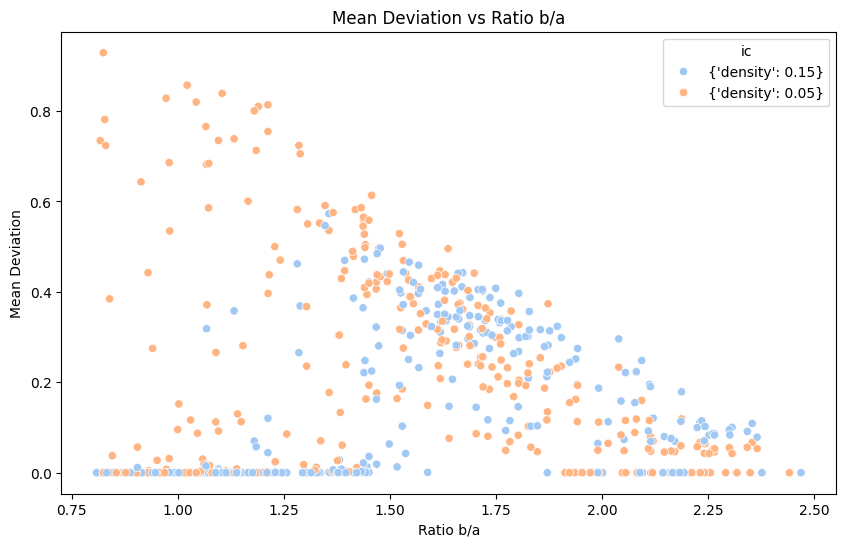

In [3]:
sns.set_palette("pastel")
# for dudv, df1 in df.groupby("du_dv"):
#     print(dudv)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df, x='ratio_b_a', y='rel_std_u', hue="ic")
plt.xlabel('Ratio b/a')
plt.ylabel('Mean Deviation')
plt.title('Mean Deviation vs Ratio b/a')
# plt.xscale('log')
# plt.yscale('log')
plt.show()

In [4]:
def plot_ball_behavior(df, start_frame=0, metric="dev", fig=None, label=None, joint=False):
    """
    Plot the mean and mean + std of the given metric,
    as well as the trajectory with the minimum final value.
    Returns a Plotly figure.
    """
    
    all_metrics, title = get_metrics_array(df, start_frame=start_frame, metric=metric)
    all_metrics = np.array(all_metrics)
    row = df.iloc[0]
    dt = row["dt"] * row["Nt"] / row["n_snapshots"]
    t = np.linspace(start_frame * dt, row["n_snapshots"] * dt, row["n_snapshots"] - start_frame)
    # Compute mean and std
    avg_metric = np.mean(all_metrics, axis=0)
    std_metric = np.std(all_metrics, axis=0)

    ids = ["u", "v"]
    traj_count = 2
    if joint:
        avg_metric_uv = avg_metric
        avg_metric = np.mean(avg_metric_uv, axis=1)
        std_metric = np.linalg.norm(avg_metric_uv, axis=1)
        ids = ["u+v"]
        traj_count = 1

    for j in range(traj_count):
        id = ids[j]
        min_idx = np.argmin(all_metrics[:, -1, j])
        min_row = all_metrics[min_idx, :, j]

        avg_metric_loc = avg_metric[:, j]
        std_metric_loc = std_metric[:, j]
        # Create figure
        if fig is None:
            fig = go.Figure()

        fig.add_trace(
            go.Scatter(
                x=np.concatenate([t, t[::-1]]),
                y=np.concatenate([avg_metric_loc + std_metric_loc, (avg_metric_loc)[::-1]]),
                fill="toself",
                fillcolor="rgba(0,100,80,0.2)",
                line=dict(color="rgba(255,255,255,0)"),
                showlegend=False,
            )
        )

        text_avg = title
        text_std = f"Min({title})"
        if label is not None:
            text_avg += f"({label})"
            text_std += f"({label})"
        text_avg += f", {id}"
        text_std += f", {id}"

        # Add mean line
        fig.add_trace(
            go.Scatter(
                x=t,
                y=avg_metric_loc,
                mode="lines",
                name=text_avg,
                hovertemplate="Index: %{x}<br>Deviation: %{y:.2f}<extra></extra>",
            )
        )

        fig.add_trace(
            go.Scatter(
                x=t,
                y=min_row,
                mode="lines",
                name=text_std,
                hovertemplate="Index: %{x}<br>Min: %{y:.2f}<extra></extra>",
            )
        )

    # Update layout
    fig.update_layout(
        title="Deviation Metrics",
        xaxis_title="Time Step/Index",
        yaxis_title="Deviation Value",
        hovermode="x unified",
        showlegend=True,
        template="plotly_white",
    )

    return fig


In [5]:
for op, df1 in df.groupby("op"):
    fig = plot_ball_behavior(df1, start_frame=80, metric="std", joint=False)
    fig.show()

KeyboardInterrupt: 

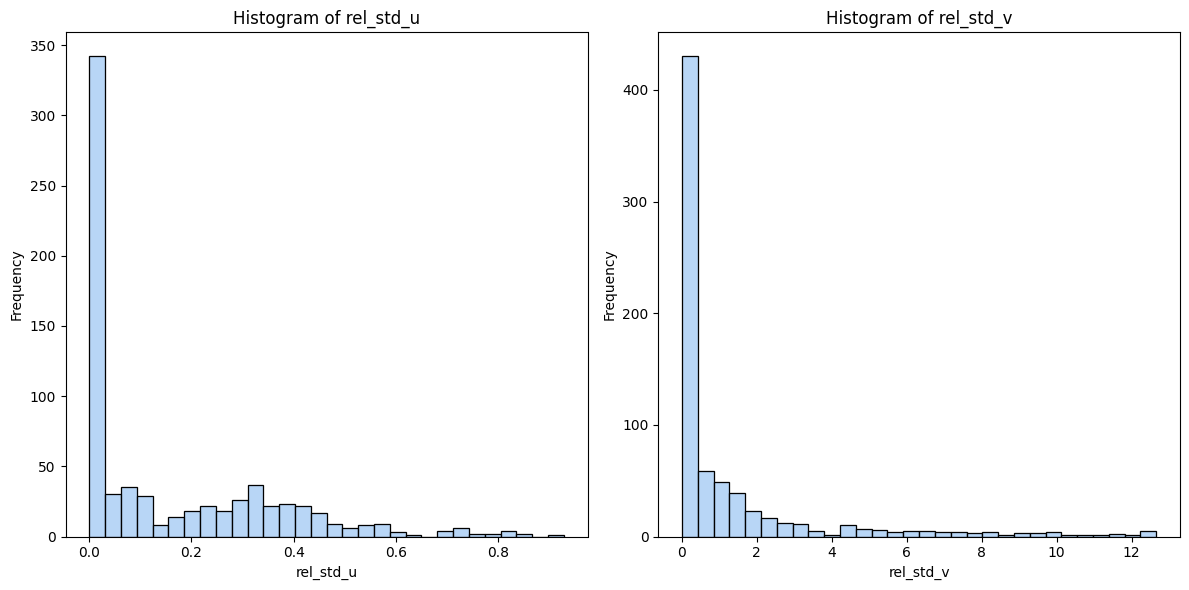

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df['rel_std_u'], bins=30, ax=axes[0])
axes[0].set_xlabel('rel_std_u')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Histogram of rel_std_u')

sns.histplot(df['rel_std_v'], bins=30, ax=axes[1])
axes[1].set_xlabel('rel_std_v')
axes[1].set_ylabel('Frequency')
axes[1].set_title('Histogram of rel_std_v')
plt.tight_layout()
plt.show() 

In [4]:
df_u = df[df.rel_std_u < 1e-1]
# print(len(df), len(df_u))
# sns.histplot(df_u, x="rel_std_v", hue="ic", multiple="stack")
df_conv = df_u[df_u.rel_std_v < 4]
df_int = df_u[df_u.rel_std_v >= 4]

In [5]:
start_frame = 70

In [6]:
df1 = df_conv.sample(n=5)
df2 = df_int.sample(n=5)
df1 = df1.reset_index()
df2 = df2.reset_index();

0    0.000471
1    0.000000
2    0.000036
3    0.000077
4    0.000036
Name: rel_std_v, dtype: float64
[[6.76201477e+02 5.57434631e+02]
 [6.00760437e+02 4.91028748e+02]
 [5.83515442e+02 4.45524902e+02]
 [5.50807556e+02 4.15975067e+02]
 [5.28843689e+02 3.95245544e+02]
 [5.07206940e+02 3.75756958e+02]
 [4.95790039e+02 3.67851868e+02]
 [4.88791199e+02 3.57873901e+02]
 [4.87729126e+02 3.56224457e+02]
 [4.84943939e+02 3.52347137e+02]
 [4.81036102e+02 3.48407806e+02]
 [4.82115662e+02 3.50028900e+02]
 [4.81742645e+02 3.46779694e+02]
 [4.86720886e+02 3.51578003e+02]
 [4.88812988e+02 3.49429077e+02]
 [4.93298126e+02 3.53936615e+02]
 [4.94608978e+02 3.53052856e+02]
 [4.96692963e+02 3.54867218e+02]
 [5.00141998e+02 3.57995605e+02]
 [5.00670166e+02 3.57130219e+02]
 [5.04465759e+02 3.61689575e+02]
 [5.06036316e+02 3.59994781e+02]
 [5.10022766e+02 3.62790802e+02]
 [5.12580566e+02 3.62095978e+02]
 [5.12765564e+02 3.60014282e+02]
 [5.12056641e+02 3.59178162e+02]
 [5.07162933e+02 3.52582886e+02]
 [5.046

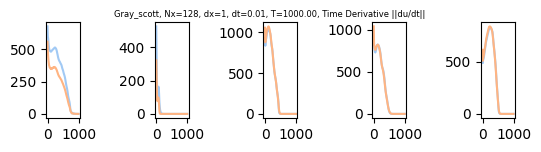

In [8]:
print(df1["rel_std_v"])
# metrics_grid(df1, start_frame, var1="", metric="std", scale=0.3);
metrics_grid(df1, 0, var1="", metric="dt", scale=0.3);

# for i, row in df1.iterrows():
#     make_animation(get_data(row), i, "out/gs")

0    7.195945
1    4.927713
2    8.914853
3    7.581077
4    5.883276
Name: rel_std_v, dtype: float64
[[ 0.         29.05167389]
 [ 0.04484259 10.67708683]
 [ 0.07365666  7.64561653]
 [ 0.09209073  6.26856756]
 [ 0.10250945  5.45232916]
 [ 0.10872082  4.9854784 ]
 [ 0.1110003   4.71132755]
 [ 0.10975358  4.55641127]
 [ 0.10567346  4.49316692]
 [ 0.09944265  4.510499  ]
 [ 0.0916799   4.60555935]
 [ 0.08296589  4.78121185]
 [ 0.07386649  5.04443789]
 [ 0.06494465  5.40869999]
 [ 0.05679984  5.8944869 ]
 [ 0.04993916  6.48135996]
 [ 0.04457908  7.10906649]
 [ 0.04087264  7.7678628 ]
 [ 0.03921515  8.43504047]
 [ 0.04016564  9.00499916]
 [ 0.04406761  9.29540348]
 [ 0.04998113  9.17582321]
 [ 0.0559316   8.72329998]
 [ 0.06107327  8.18608475]
 [ 0.06549613  7.72310972]
 [ 0.0689841   7.35218143]
 [ 0.07124429  7.06201267]
 [ 0.07220444  6.84797001]
 [ 0.07201566  6.71061039]
 [ 0.07094469  6.6503768 ]
 [ 0.06924013  6.65888214]
 [ 0.06715491  6.72618008]
 [ 0.06496404  6.8424778 ]
 [ 0.06

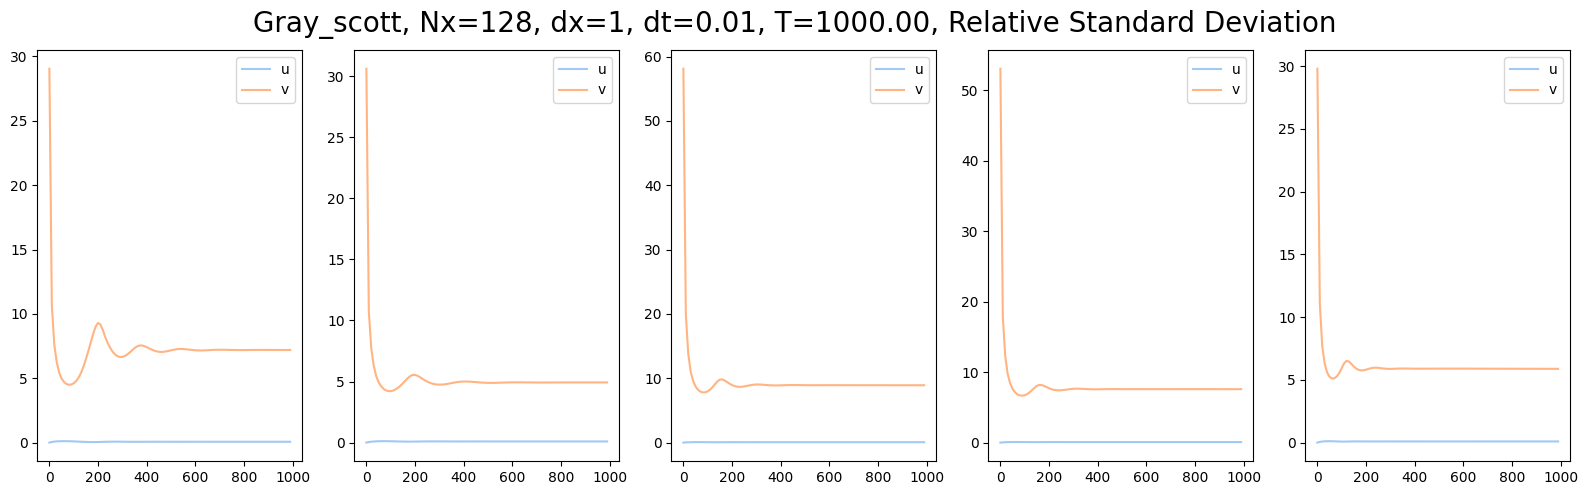

[[5.84101990e+02 4.10041687e+02]
 [4.79548706e+02 3.52489868e+02]
 [3.79236267e+02 2.51273438e+02]
 [2.74651337e+02 1.70280167e+02]
 [1.95420120e+02 1.29164566e+02]
 [1.30028595e+02 8.68664856e+01]
 [8.18834839e+01 6.12052612e+01]
 [6.42844772e+01 5.49915695e+01]
 [7.60909576e+01 5.80880013e+01]
 [9.60900421e+01 6.30156593e+01]
 [1.12975304e+02 6.64016800e+01]
 [1.23653618e+02 6.70954590e+01]
 [1.27943535e+02 6.54397888e+01]
 [1.25809998e+02 6.16312294e+01]
 [1.15716476e+02 5.39146996e+01]
 [9.93641891e+01 4.39401474e+01]
 [8.23000412e+01 3.68218880e+01]
 [6.69940262e+01 3.27639694e+01]
 [5.81472244e+01 3.56538200e+01]
 [6.66204224e+01 4.85582581e+01]
 [8.41133347e+01 6.02840195e+01]
 [9.01364822e+01 5.95771027e+01]
 [8.73867188e+01 5.70927238e+01]
 [8.73724136e+01 5.99616699e+01]
 [8.54520874e+01 5.80616074e+01]
 [7.72325592e+01 5.07938004e+01]
 [6.42027664e+01 4.14782066e+01]
 [4.99636841e+01 3.27449150e+01]
 [3.97424622e+01 2.72829399e+01]
 [3.45668259e+01 2.37451420e+01]
 [3.297727

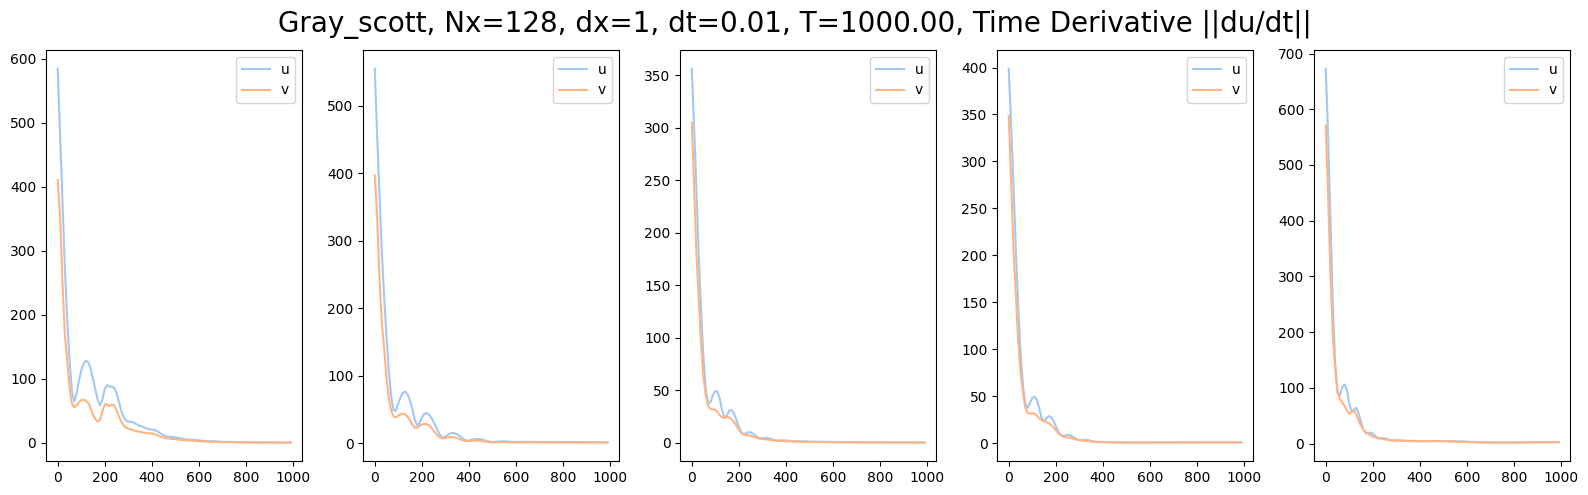

In [11]:
print(df2["rel_std_v"])
metrics_grid(df2, 0, var1="", metric="std");
metrics_grid(df2, 0, var1="", metric="dt");
# for i, row in df1.iterrows():
#     make_animation(get_data(row), f"std_{i}", "out/gs")